# Import Libraries

In [31]:
import os
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
import torchvision.utils as vutils
import torch.nn.functional as F
import matplotlib.pyplot as plt

from tqdm import tqdm
from PIL import Image
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader

# Set random seed for reproducibility
torch.manual_seed(42)

# Get Device

In [25]:
if torch.backends.mps.is_available():
    # Apple Silicon Mac with Metal support
    device = torch.device("mps")
    print("Using MPS (Metal Performance Shaders) for Apple Silicon Mac")
elif torch.cuda.is_available():
    # Intel Mac with external GPU
    device = torch.device("cuda")
    print("Using CUDA GPU")
else:
    # Fallback to CPU
    device = torch.device("cpu")
    print("Using CPU - training will be slower")
    
print(f"Using device: {device}")

Using MPS (Metal Performance Shaders) for Apple Silicon Mac
Using device: mps


# Create Dataset and Data Loaders

In [26]:
class LOLDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with LOL dataset structure
            transform (callable, optional): Optional transform to be applied on images
        """
        self.root_dir = root_dir
        self.transform = transform
        
        # Assuming LOL dataset structure with 'low' and 'normal' subdirectories
        self.low_light_dir = os.path.join(root_dir, 'low')
        self.normal_light_dir = os.path.join(root_dir, 'normal')
        
        # Get image file names (assuming same names in both directories)
        self.image_names = sorted(os.listdir(self.low_light_dir))
    
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        
        # Load low-light and normal-light images
        low_light_path = os.path.join(self.low_light_dir, img_name)
        normal_light_path = os.path.join(self.normal_light_dir, img_name)
        
        low_light_image = Image.open(low_light_path).convert('RGB')
        normal_light_image = Image.open(normal_light_path).convert('RGB')
        
        # Apply transformations
        if self.transform:
            low_light_image = self.transform(low_light_image)
            normal_light_image = self.transform(normal_light_image)
        
        return {'low': low_light_image, 'normal': normal_light_image}

# Default image transformations
def get_transforms():
    return transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        # Images normalized to [-1, 1] range for GAN training
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]) 

num_workers = 0 if device.type == 'mps' else 2

# Create datasets and data loaders
transform = get_transforms()

train_dataset = LOLDataset(
    root_dir=os.path.join("data", "train"),
    transform=transform
)

val_dataset = LOLDataset(
    root_dir=os.path.join("data", "val"),
    transform=transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=num_workers
)

val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=num_workers
)

# Create and Initilize models

## Create and initialize the U-Net Generator

In [27]:
class UNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, bn=True, dropout=False, relu=True):
        super(UNetBlock, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False) if down 
            else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(out_channels) if bn else nn.Identity(),
            nn.GELU(),
            nn.Dropout(0.5) if dropout else nn.Identity()
        )
    
    def forward(self, x):
        return self.conv(x)

class UNetGenerator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=64):
        super(UNetGenerator, self).__init__()
        
        # Encoder (downsampling)
        self.down1 = UNetBlock(in_channels, features, down=True, bn=False, relu=False)  # 128x128
        self.down2 = UNetBlock(features, features*2, down=True)  # 64x64
        self.down3 = UNetBlock(features*2, features*4, down=True)  # 32x32
        self.down4 = UNetBlock(features*4, features*8, down=True)  # 16x16
        self.down5 = UNetBlock(features*8, features*8, down=True)  # 8x8
        self.down6 = UNetBlock(features*8, features*8, down=True)  # 4x4
        self.down7 = UNetBlock(features*8, features*8, down=True, bn=False)  # 2x2
        
        # Decoder (upsampling with skip connections)
        self.up1 = UNetBlock(features*8, features*8, down=False, dropout=True)  # 4x4
        self.up2 = UNetBlock(features*8*2, features*8, down=False, dropout=True)  # 8x8
        self.up3 = UNetBlock(features*8*2, features*8, down=False, dropout=True)  # 16x16
        self.up4 = UNetBlock(features*8*2, features*4, down=False)  # 32x32
        self.up5 = UNetBlock(features*4*2, features*2, down=False)  # 64x64
        self.up6 = UNetBlock(features*2*2, features, down=False)  # 128x128
        
        # Final output layer
        self.final = nn.Sequential(
            nn.ConvTranspose2d(features*2, out_channels, 4, 2, 1),
            nn.Tanh()
        )
    
    def forward(self, x):
        # Encoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        
        # Decoder with skip connections
        u1 = self.up1(d7)
        u2 = self.up2(torch.cat([u1, d6], 1))
        u3 = self.up3(torch.cat([u2, d5], 1))
        u4 = self.up4(torch.cat([u3, d4], 1))
        u5 = self.up5(torch.cat([u4, d3], 1))
        u6 = self.up6(torch.cat([u5, d2], 1))
        
        return self.final(torch.cat([u6, d1], 1)) 

generator = UNetGenerator().to(device)

## Create and initialize the PatchGAN discriminator

In [28]:
class PatchGANDiscriminator(nn.Module):
    def __init__(self, in_channels=6, features=64):
        super(PatchGANDiscriminator, self).__init__()
        
        # Input: concatenated low-light and enhanced/normal image (6 channels)
        self.conv1 = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(in_channels, features, 4, 2, 1)),
            nn.GELU()
        )
        
        self.conv2 = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(features, features*2, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(features*2),
            nn.GELU()
        )
        
        self.conv3 = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(features*2, features*4, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(features*4),
            nn.GELU()
        )
        
        self.conv4 = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(features*4, features*8, 4, 1, 1, bias=False)),
            nn.BatchNorm2d(features*8),
            nn.GELU()
        )
        
        # Output: 1-channel prediction map
        self.final = nn.utils.spectral_norm(nn.Conv2d(features*8, 1, 4, 1, 1))
    
    def forward(self, x, y):
        # x: low-light image, y: enhanced/normal image
        input_tensor = torch.cat([x, y], dim=1)
        x1 = self.conv1(input_tensor)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x4 = self.conv4(x3)
        x = self.final(x4)
        return x, [x1, x2, x3, x4] 

discriminator = PatchGANDiscriminator().to(device)

## Create and initialize loss functions

In [29]:
class VGGPerceptualLoss(nn.Module):
    def __init__(self, device):
        super(VGGPerceptualLoss, self).__init__()
        # Updated for newer PyTorch versions and Mac compatibility
        vgg = models.vgg16(weights=models.VGG16_Weights.DEFAULT).features
        vgg = vgg.to(device).eval()
        
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        
        for x in range(4):
            self.slice1.add_module(str(x), vgg[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg[x])
        for x in range(16, 23):
            self.slice4.add_module(str(x), vgg[x])
        
        # Freeze parameters
        for param in self.parameters():
            param.requires_grad = False
        
        self.device = device
    
    def forward(self, x, y):
        # Normalize to match VGG input
        mean = torch.Tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(self.device)
        std = torch.Tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(self.device)
        
        # Convert from [-1, 1] to [0, 1] range
        x = (x + 1) / 2
        y = (y + 1) / 2
        
        # Normalize
        x = (x - mean) / std
        y = (y - mean) / std
        
        # Get feature maps
        x_features = [self.slice1(x), self.slice2(self.slice1(x)), 
                      self.slice3(self.slice2(self.slice1(x))), 
                      self.slice4(self.slice3(self.slice2(self.slice1(x))))]
        y_features = [self.slice1(y), self.slice2(self.slice1(y)), 
                      self.slice3(self.slice2(self.slice1(y))), 
                      self.slice4(self.slice3(self.slice2(self.slice1(y))))]
        
        # Calculate L1 loss on feature maps
        loss = 0
        weights = [1.0/32, 1.0/16, 1.0/8, 1.0/4]
        for i in range(len(x_features)):
            loss += weights[i] * F.l1_loss(x_features[i], y_features[i])
        
        return loss

# Adversarial loss
adversarial_loss = nn.BCEWithLogitsLoss()

# L1 Loss
l1_loss = nn.L1Loss() 

# Training loop

Epoch 1/50: 100%|██████████| 122/122 [00:59<00:00,  2.04it/s]


Epoch 1/50 - G Loss: 122.2978, D Loss: 0.4420, Val PSNR: 15.86, Val SSIM: 0.7703


Epoch 2/50: 100%|██████████| 122/122 [00:59<00:00,  2.07it/s]


Epoch 2/50 - G Loss: 86.1567, D Loss: 0.3285, Val PSNR: 17.01, Val SSIM: 0.8131


Epoch 3/50: 100%|██████████| 122/122 [00:58<00:00,  2.10it/s]


Epoch 3/50 - G Loss: 81.1715, D Loss: 0.3292, Val PSNR: 17.43, Val SSIM: 0.8419


Epoch 4/50: 100%|██████████| 122/122 [00:58<00:00,  2.08it/s]


Epoch 4/50 - G Loss: 78.2983, D Loss: 0.3263, Val PSNR: 17.66, Val SSIM: 0.8473


Epoch 5/50: 100%|██████████| 122/122 [00:58<00:00,  2.08it/s]


Epoch 5/50 - G Loss: 77.1012, D Loss: 0.3261, Val PSNR: 17.76, Val SSIM: 0.8559


Epoch 6/50: 100%|██████████| 122/122 [00:58<00:00,  2.08it/s]


Epoch 6/50 - G Loss: 75.4931, D Loss: 0.3281, Val PSNR: 18.10, Val SSIM: 0.8637


Epoch 7/50: 100%|██████████| 122/122 [00:59<00:00,  2.07it/s]


Epoch 7/50 - G Loss: 73.7360, D Loss: 0.3258, Val PSNR: 18.13, Val SSIM: 0.8571


Epoch 8/50: 100%|██████████| 122/122 [00:59<00:00,  2.06it/s]


Epoch 8/50 - G Loss: 73.0358, D Loss: 0.3272, Val PSNR: 18.78, Val SSIM: 0.8773


Epoch 9/50: 100%|██████████| 122/122 [01:00<00:00,  2.03it/s]


Epoch 9/50 - G Loss: 70.1668, D Loss: 0.3269, Val PSNR: 18.77, Val SSIM: 0.8848


Epoch 10/50: 100%|██████████| 122/122 [01:00<00:00,  2.01it/s]


Epoch 10/50 - G Loss: 68.2633, D Loss: 0.3265, Val PSNR: 19.11, Val SSIM: 0.8787


Epoch 11/50: 100%|██████████| 122/122 [01:00<00:00,  2.01it/s]


Epoch 11/50 - G Loss: 66.2032, D Loss: 0.3293, Val PSNR: 19.36, Val SSIM: 0.8818


Epoch 12/50: 100%|██████████| 122/122 [01:00<00:00,  2.02it/s]


Epoch 12/50 - G Loss: 63.5524, D Loss: 0.3266, Val PSNR: 19.68, Val SSIM: 0.8915


Epoch 13/50: 100%|██████████| 122/122 [01:00<00:00,  2.02it/s]


Epoch 13/50 - G Loss: 60.7832, D Loss: 0.3407, Val PSNR: 19.99, Val SSIM: 0.8931


Epoch 14/50: 100%|██████████| 122/122 [01:00<00:00,  2.02it/s]


Epoch 14/50 - G Loss: 58.0694, D Loss: 0.4125, Val PSNR: 20.33, Val SSIM: 0.9043


Epoch 15/50: 100%|██████████| 122/122 [01:00<00:00,  2.01it/s]


Epoch 15/50 - G Loss: 55.4543, D Loss: 0.3363, Val PSNR: 20.84, Val SSIM: 0.9059


Epoch 16/50: 100%|██████████| 122/122 [01:00<00:00,  2.01it/s]


Epoch 16/50 - G Loss: 54.0843, D Loss: 0.3383, Val PSNR: 21.02, Val SSIM: 0.9089


Epoch 17/50: 100%|██████████| 122/122 [01:00<00:00,  2.00it/s]


Epoch 17/50 - G Loss: 52.3527, D Loss: 0.3299, Val PSNR: 19.99, Val SSIM: 0.9147


Epoch 18/50: 100%|██████████| 122/122 [01:00<00:00,  2.00it/s]


Epoch 18/50 - G Loss: 51.4523, D Loss: 0.3313, Val PSNR: 21.92, Val SSIM: 0.9285


Epoch 19/50: 100%|██████████| 122/122 [01:01<00:00,  1.99it/s]


Epoch 19/50 - G Loss: 50.2880, D Loss: 0.3327, Val PSNR: 21.01, Val SSIM: 0.9150


Epoch 20/50: 100%|██████████| 122/122 [01:07<00:00,  1.80it/s]


Epoch 20/50 - G Loss: 49.3755, D Loss: 0.3288, Val PSNR: 21.58, Val SSIM: 0.9197


Epoch 21/50: 100%|██████████| 122/122 [01:02<00:00,  1.95it/s]


Epoch 21/50 - G Loss: 48.6486, D Loss: 0.3274, Val PSNR: 21.07, Val SSIM: 0.9287


Epoch 22/50: 100%|██████████| 122/122 [01:04<00:00,  1.89it/s]


Epoch 22/50 - G Loss: 47.0871, D Loss: 0.3276, Val PSNR: 20.82, Val SSIM: 0.9197


Epoch 23/50: 100%|██████████| 122/122 [01:03<00:00,  1.92it/s]


Epoch 23/50 - G Loss: 47.0453, D Loss: 0.3273, Val PSNR: 21.65, Val SSIM: 0.9326


Epoch 24/50: 100%|██████████| 122/122 [01:02<00:00,  1.95it/s]


Epoch 24/50 - G Loss: 46.0404, D Loss: 0.3282, Val PSNR: 21.72, Val SSIM: 0.9294


Epoch 25/50: 100%|██████████| 122/122 [01:01<00:00,  1.97it/s]


Epoch 25/50 - G Loss: 45.6404, D Loss: 0.3287, Val PSNR: 21.66, Val SSIM: 0.9217


Epoch 26/50: 100%|██████████| 122/122 [01:01<00:00,  1.98it/s]


Epoch 26/50 - G Loss: 44.5812, D Loss: 0.3277, Val PSNR: 21.44, Val SSIM: 0.9261


Epoch 27/50: 100%|██████████| 122/122 [01:01<00:00,  1.98it/s]


Epoch 27/50 - G Loss: 43.7983, D Loss: 0.3286, Val PSNR: 21.36, Val SSIM: 0.9272


Epoch 28/50: 100%|██████████| 122/122 [01:01<00:00,  1.99it/s]


Epoch 28/50 - G Loss: 42.7064, D Loss: 0.3276, Val PSNR: 21.61, Val SSIM: 0.9299


Epoch 29/50: 100%|██████████| 122/122 [01:01<00:00,  2.00it/s]


Epoch 29/50 - G Loss: 42.0677, D Loss: 0.3281, Val PSNR: 21.42, Val SSIM: 0.9292


Epoch 30/50: 100%|██████████| 122/122 [01:24<00:00,  1.44it/s]


Epoch 30/50 - G Loss: 41.8415, D Loss: 0.3267, Val PSNR: 21.47, Val SSIM: 0.9249


Epoch 31/50: 100%|██████████| 122/122 [00:59<00:00,  2.03it/s]


Epoch 31/50 - G Loss: 41.8806, D Loss: 0.3274, Val PSNR: 21.58, Val SSIM: 0.9187


Epoch 32/50: 100%|██████████| 122/122 [01:01<00:00,  1.98it/s]


Epoch 32/50 - G Loss: 41.4295, D Loss: 0.3274, Val PSNR: 21.71, Val SSIM: 0.9263


Epoch 33/50: 100%|██████████| 122/122 [01:01<00:00,  1.97it/s]


Epoch 33/50 - G Loss: 40.7700, D Loss: 0.3268, Val PSNR: 21.77, Val SSIM: 0.9309


Epoch 34/50: 100%|██████████| 122/122 [01:02<00:00,  1.96it/s]


Epoch 34/50 - G Loss: 41.0899, D Loss: 0.3264, Val PSNR: 21.49, Val SSIM: 0.9279


Epoch 35/50: 100%|██████████| 122/122 [01:02<00:00,  1.95it/s]


Epoch 35/50 - G Loss: 39.8683, D Loss: 0.3270, Val PSNR: 21.97, Val SSIM: 0.9284


Epoch 36/50: 100%|██████████| 122/122 [01:02<00:00,  1.96it/s]


Epoch 36/50 - G Loss: 39.6185, D Loss: 0.3267, Val PSNR: 20.93, Val SSIM: 0.9260


Epoch 37/50: 100%|██████████| 122/122 [01:02<00:00,  1.94it/s]


Epoch 37/50 - G Loss: 39.4092, D Loss: 0.3299, Val PSNR: 21.41, Val SSIM: 0.9284


Epoch 38/50: 100%|██████████| 122/122 [01:01<00:00,  1.97it/s]


Epoch 38/50 - G Loss: 39.6327, D Loss: 0.3270, Val PSNR: 21.23, Val SSIM: 0.9248


Epoch 39/50: 100%|██████████| 122/122 [01:02<00:00,  1.97it/s]


Epoch 39/50 - G Loss: 39.1384, D Loss: 0.3273, Val PSNR: 21.59, Val SSIM: 0.9277


Epoch 40/50: 100%|██████████| 122/122 [01:01<00:00,  1.97it/s]


Epoch 40/50 - G Loss: 38.2726, D Loss: 0.3267, Val PSNR: 21.65, Val SSIM: 0.9319


Epoch 41/50: 100%|██████████| 122/122 [01:01<00:00,  1.99it/s]


Epoch 41/50 - G Loss: 38.4469, D Loss: 0.3267, Val PSNR: 20.58, Val SSIM: 0.9263


Epoch 42/50: 100%|██████████| 122/122 [01:01<00:00,  1.98it/s]


Epoch 42/50 - G Loss: 38.0934, D Loss: 0.3272, Val PSNR: 21.87, Val SSIM: 0.9315


Epoch 43/50: 100%|██████████| 122/122 [01:02<00:00,  1.94it/s]


Epoch 43/50 - G Loss: 38.1845, D Loss: 0.3272, Val PSNR: 21.82, Val SSIM: 0.9336


Epoch 44/50: 100%|██████████| 122/122 [01:01<00:00,  1.98it/s]


Epoch 44/50 - G Loss: 38.0662, D Loss: 0.3270, Val PSNR: 21.72, Val SSIM: 0.9350


Epoch 45/50: 100%|██████████| 122/122 [01:01<00:00,  2.00it/s]


Epoch 45/50 - G Loss: 37.3252, D Loss: 0.3268, Val PSNR: 21.28, Val SSIM: 0.9247


Epoch 46/50: 100%|██████████| 122/122 [01:01<00:00,  2.00it/s]


Epoch 46/50 - G Loss: 37.1938, D Loss: 0.3262, Val PSNR: 21.84, Val SSIM: 0.9331


Epoch 47/50: 100%|██████████| 122/122 [01:01<00:00,  1.99it/s]


Epoch 47/50 - G Loss: 37.0693, D Loss: 0.3272, Val PSNR: 21.72, Val SSIM: 0.9326


Epoch 48/50: 100%|██████████| 122/122 [01:01<00:00,  1.97it/s]


Epoch 48/50 - G Loss: 37.0553, D Loss: 0.3294, Val PSNR: 21.74, Val SSIM: 0.9294


Epoch 49/50: 100%|██████████| 122/122 [01:01<00:00,  1.97it/s]


Epoch 49/50 - G Loss: 36.8778, D Loss: 0.3263, Val PSNR: 21.99, Val SSIM: 0.9350


Epoch 50/50: 100%|██████████| 122/122 [01:01<00:00,  1.97it/s]


Epoch 50/50 - G Loss: 36.3664, D Loss: 0.3257, Val PSNR: 21.81, Val SSIM: 0.9349


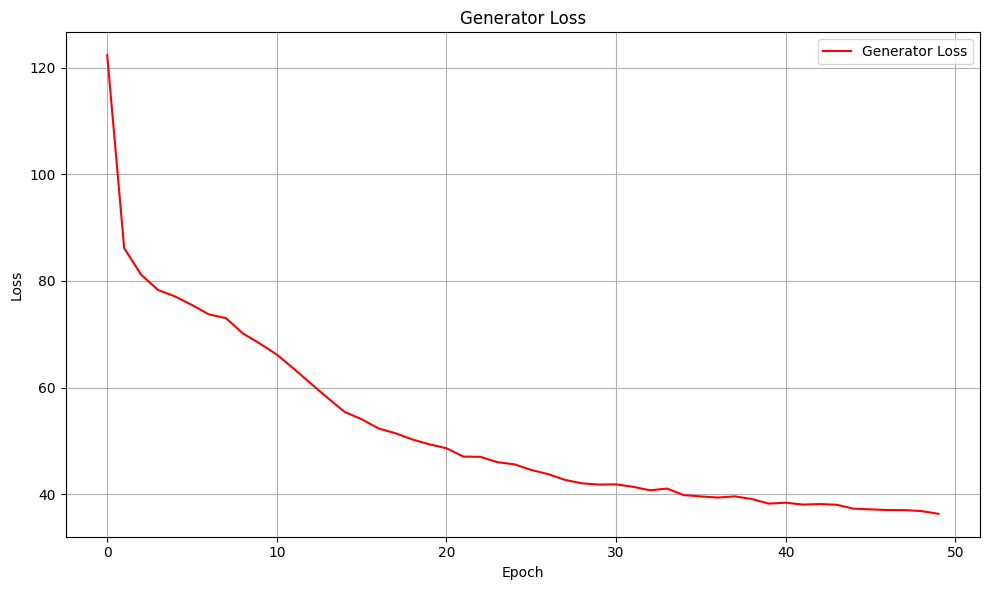

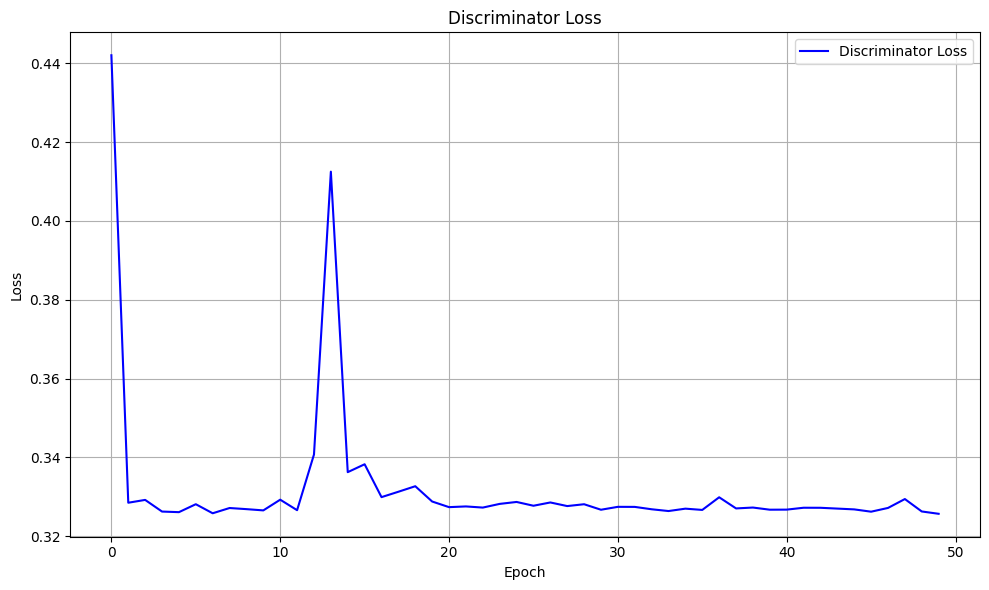

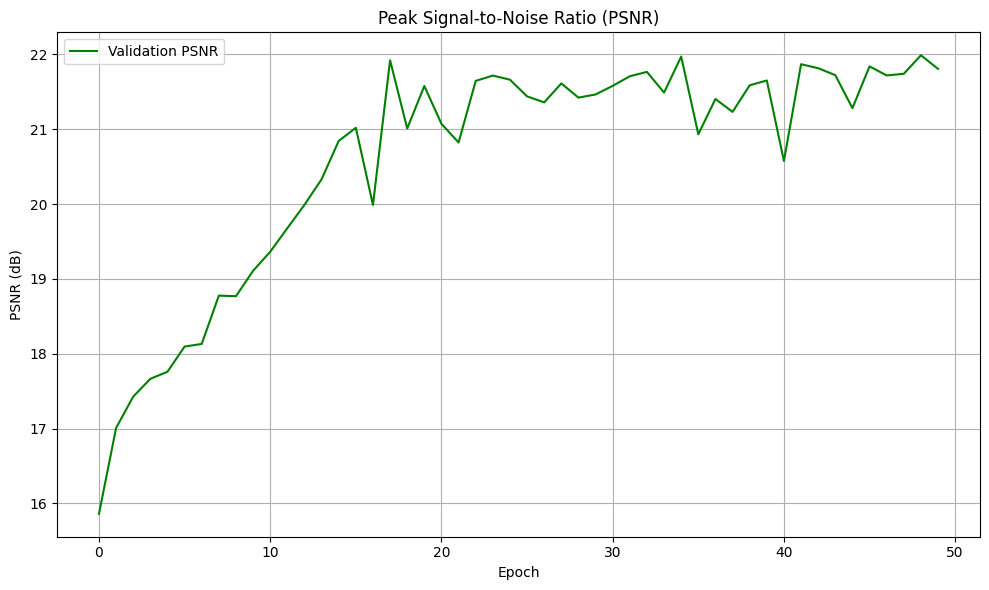

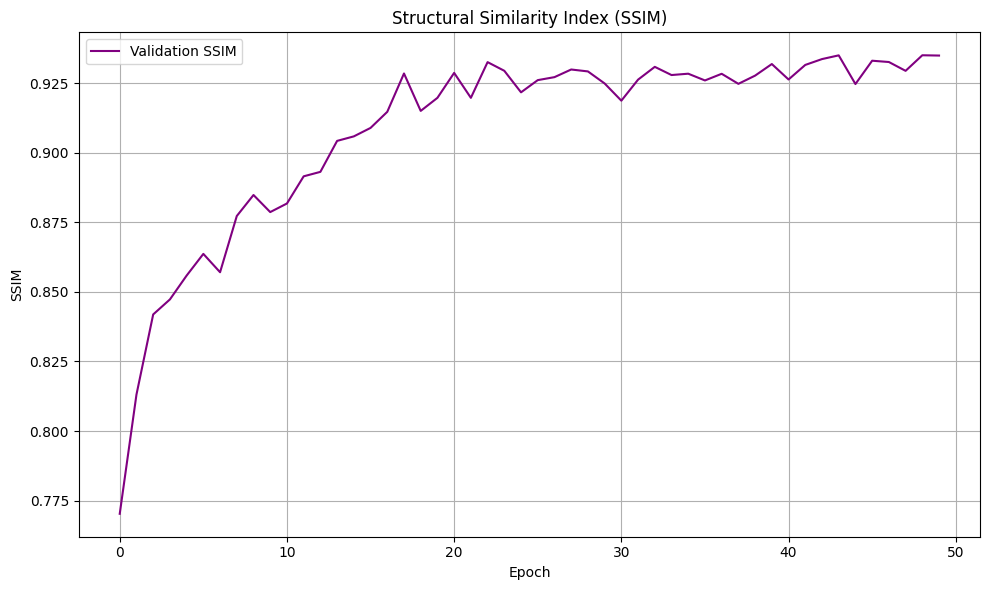

Training completed and model saved.


In [32]:
def psnr(img1, img2):
    """Calculate PSNR between two images."""
    # Convert from [-1, 1] to [0, 1] range
    img1 = (img1 + 1) / 2
    img2 = (img2 + 1) / 2
    
    mse = torch.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    
    max_pixel = 1.0
    psnr_val = 20 * torch.log10(max_pixel / torch.sqrt(mse))
    return psnr_val.item()

def ssim(img1, img2):
    """Calculate SSIM between two images."""
    # Convert from [-1, 1] to [0, 1] range
    img1 = (img1 + 1) / 2
    img2 = (img2 + 1) / 2
    
    C1 = (0.01 * 1) ** 2
    C2 = (0.03 * 1) ** 2
    
    img1 = img1.permute(0, 2, 3, 1).cpu().numpy()
    img2 = img2.permute(0, 2, 3, 1).cpu().numpy()
    
    mu1 = np.mean(img1, axis=(1, 2), keepdims=True)
    mu2 = np.mean(img2, axis=(1, 2), keepdims=True)
    
    sigma1 = np.std(img1, axis=(1, 2), keepdims=True)
    sigma2 = np.std(img2, axis=(1, 2), keepdims=True)
    
    sigma12 = np.mean((img1 - mu1) * (img2 - mu2), axis=(1, 2), keepdims=True)
    
    ssim_map = ((2 * mu1 * mu2 + C1) * (2 * sigma12 + C2)) / ((mu1**2 + mu2**2 + C1) * (sigma1**2 + sigma2**2 + C2))
    return np.mean(ssim_map) 

def plot_training_history(history):
    """
    Plot training history metrics and save each plot separately.
    
    Args:
        history (dict): Dictionary containing training metrics
    """
    # Create directory for plots if it doesn't exist
    os.makedirs('plots', exist_ok=True)
    
    # Plot generator loss
    plt.figure(figsize=(10, 6))
    plt.plot(history['g_loss'], label='Generator Loss', color='red')
    plt.title('Generator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # Plot discriminator loss
    plt.figure(figsize=(10, 6))
    plt.plot(history['d_loss'], label='Discriminator Loss', color='blue')
    plt.title('Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # Plot PSNR
    plt.figure(figsize=(10, 6))
    plt.plot(history['val_psnr'], label='Validation PSNR', color='green')
    plt.title('Peak Signal-to-Noise Ratio (PSNR)')
    plt.xlabel('Epoch')
    plt.ylabel('PSNR (dB)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # Plot SSIM
    plt.figure(figsize=(10, 6))
    plt.plot(history['val_ssim'], label='Validation SSIM', color='purple')
    plt.title('Structural Similarity Index (SSIM)')
    plt.xlabel('Epoch')
    plt.ylabel('SSIM')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.close()

def save_sample_images(generator, data_loader, epoch, device, num_samples=4):
    """
    Save sample enhanced images during training.
    
    Args:
        generator: Generator model
        data_loader: DataLoader containing validation images
        epoch (int): Current epoch number
        device: Device to run the model on
        num_samples (int): Number of samples to save
    """
    generator.eval()
    
    # Create directory for samples if it doesn't exist
    os.makedirs('samples', exist_ok=True)
    
    with torch.no_grad():
        # Get a batch of images
        batch = next(iter(data_loader))
        low_imgs = batch['low'].to(device)
        normal_imgs = batch['normal'].to(device)
        
        # Generate enhanced images
        enhanced_imgs = generator(low_imgs)
        
        # Create a grid of images
        comparison = torch.cat([low_imgs[:num_samples], 
                              enhanced_imgs[:num_samples], 
                              normal_imgs[:num_samples]], dim=0)
        
        # Save the grid
        vutils.save_image(comparison,
                         f'samples/comparison_epoch_{epoch}.png',
                         normalize=True,
                         nrow=num_samples)
        
def evaluate_model(generator, data_loader, device):
    """Evaluate model with PSNR and SSIM metrics."""
    generator.eval()
    total_psnr = 0.0
    total_ssim = 0.0
    
    with torch.no_grad():
        for batch in data_loader:
            low_imgs = batch['low'].to(device)
            normal_imgs = batch['normal'].to(device)
            
            # Generate enhanced images
            enhanced_imgs = generator(low_imgs)
            
            # Calculate metrics for each image in batch
            for i in range(low_imgs.size(0)):
                total_psnr += psnr(enhanced_imgs[i:i+1], normal_imgs[i:i+1])
                total_ssim += ssim(enhanced_imgs[i:i+1], normal_imgs[i:i+1])
    
    # Calculate average metrics
    avg_psnr = total_psnr / len(data_loader.dataset)
    avg_ssim = total_ssim / len(data_loader.dataset)
    
    return avg_psnr, avg_ssim

def train_model(generator, discriminator, train_loader, val_loader, num_epochs=50, device=None):
    # Optimizers
    optimizer_G = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))
    
    # Learning rate schedulers with warmup
    def warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor):
        def f(x):
            if x >= warmup_iters:
                return 1
            alpha = float(x) / warmup_iters
            return warmup_factor * (1 - alpha) + alpha
        return torch.optim.lr_scheduler.LambdaLR(optimizer, f)
    
    warmup_iters = min(1000, len(train_loader) - 1)
    warmup_scheduler_G = warmup_lr_scheduler(optimizer_G, warmup_iters, 0.001)
    warmup_scheduler_D = warmup_lr_scheduler(optimizer_D, warmup_iters, 0.001)
    
    # Main schedulers with more aggressive decay
    scheduler_G = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer_G, 
        T_0=10,  # Restart every 10 epochs
        T_mult=2,  # Double the restart interval after each restart
        eta_min=1e-6
    )
    scheduler_D = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer_D, 
        T_0=10,
        T_mult=2,
        eta_min=1e-6
    )
    
    # Loss weights
    lambda_adv = 0.05
    lambda_pixel = 300.0
    lambda_perceptual = 30.0
    lambda_feature = 10.0
    
    # Initialize the perceptual loss
    perceptual_loss = VGGPerceptualLoss(device)
    
    # Training history
    history = {
        'g_loss': [], 'd_loss': [], 'val_psnr': [], 'val_ssim': []
    }
    
    # Gradient clipping value
    clip_value = 0.5
    
    for epoch in range(num_epochs):
        # Training
        generator.train()
        discriminator.train()
        
        train_g_loss = 0.0
        train_d_loss = 0.0
        
        for batch_idx, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            # Get data
            low_imgs = batch['low'].to(device)
            normal_imgs = batch['normal'].to(device)
            batch_size = low_imgs.size(0)
            
            # Real and fake labels with label smoothing
            real_label = torch.ones((batch_size, 1, 30, 30), device=device) * 0.9
            fake_label = torch.zeros((batch_size, 1, 30, 30), device=device) + 0.1
            
            #------------------------
            # Train Discriminator
            #------------------------
            optimizer_D.zero_grad()
            
            # Generate enhanced images
            with torch.no_grad():
                enhanced_imgs = generator(low_imgs)
            
            # Real loss
            pred_real, real_features = discriminator(low_imgs, normal_imgs)
            d_real_loss = adversarial_loss(pred_real, real_label)
            
            # Fake loss
            pred_fake, _ = discriminator(low_imgs, enhanced_imgs.detach())
            d_fake_loss = adversarial_loss(pred_fake, fake_label)
            
            # Total discriminator loss
            d_loss = (d_real_loss + d_fake_loss) / 2
            d_loss.backward()
            
            # Gradient clipping for discriminator
            torch.nn.utils.clip_grad_norm_(discriminator.parameters(), clip_value)
            
            optimizer_D.step()
            
            #------------------------
            # Train Generator
            #------------------------
            optimizer_G.zero_grad()
            
            # Generate enhanced images again
            enhanced_imgs = generator(low_imgs)
            
            # Adversarial loss
            pred_fake, fake_features = discriminator(low_imgs, enhanced_imgs)
            g_adv_loss = adversarial_loss(pred_fake, real_label)
            
            # Pixel-wise loss
            g_pixel_loss = l1_loss(enhanced_imgs, normal_imgs)
            
            # Perceptual loss
            g_percep_loss = perceptual_loss(enhanced_imgs, normal_imgs)
            
            # Feature matching loss
            g_feature_loss = 0.0
            for fake_feat, real_feat in zip(fake_features, real_features):
                g_feature_loss += torch.nn.functional.l1_loss(fake_feat, real_feat.detach())
            
            # Total generator loss
            g_loss = (lambda_adv * g_adv_loss + 
                     lambda_pixel * g_pixel_loss + 
                     lambda_perceptual * g_percep_loss +
                     lambda_feature * g_feature_loss)
            
            g_loss.backward()
            
            # Gradient clipping for generator
            torch.nn.utils.clip_grad_norm_(generator.parameters(), clip_value)
            
            optimizer_G.step()
            
            # Update learning rates with warmup
            if batch_idx < warmup_iters:
                warmup_scheduler_G.step()
                warmup_scheduler_D.step()
            
            # Save losses
            train_g_loss += g_loss.item()
            train_d_loss += d_loss.item()
        
        # Step the main schedulers
        scheduler_G.step()
        scheduler_D.step()
        
        # Calculate average losses
        train_g_loss /= len(train_loader)
        train_d_loss /= len(train_loader)
        
        history['g_loss'].append(train_g_loss)
        history['d_loss'].append(train_d_loss)
        
        # Validation
        val_psnr, val_ssim = evaluate_model(generator, val_loader, device)
        history['val_psnr'].append(val_psnr)
        history['val_ssim'].append(val_ssim)
        
        print(f"Epoch {epoch+1}/{num_epochs} - G Loss: {train_g_loss:.4f}, D Loss: {train_d_loss:.4f}, Val PSNR: {val_psnr:.2f}, Val SSIM: {val_ssim:.4f}")
        
        # Save sample enhanced images
        if (epoch + 1) % 5 == 0:
            save_sample_images(generator, val_loader, epoch+1, device)
        
        # Save model checkpoints
        if (epoch + 1) % 10 == 0:
            torch.save({
                'generator': generator.state_dict(),
                'discriminator': discriminator.state_dict(),
                'optimizer_G': optimizer_G.state_dict(),
                'optimizer_D': optimizer_D.state_dict(),
                'epoch': epoch,
                'history': history
            }, f"checkpoints/checkpoint_epoch_{epoch+1}.pth")
    
    return history

history = train_model(generator, discriminator, train_loader, val_loader, num_epochs=50, device=device)
    
# Plot training history
plot_training_history(history)

# Save final model
torch.save({
    'generator': generator.state_dict(),
    'discriminator': discriminator.state_dict(),
}, "checkpoints/final_model.pth")

print("Training completed and model saved.")

# Sample generated images
First row contains the low light images, the middle contains the enhanced images and the last row contains the normal light images

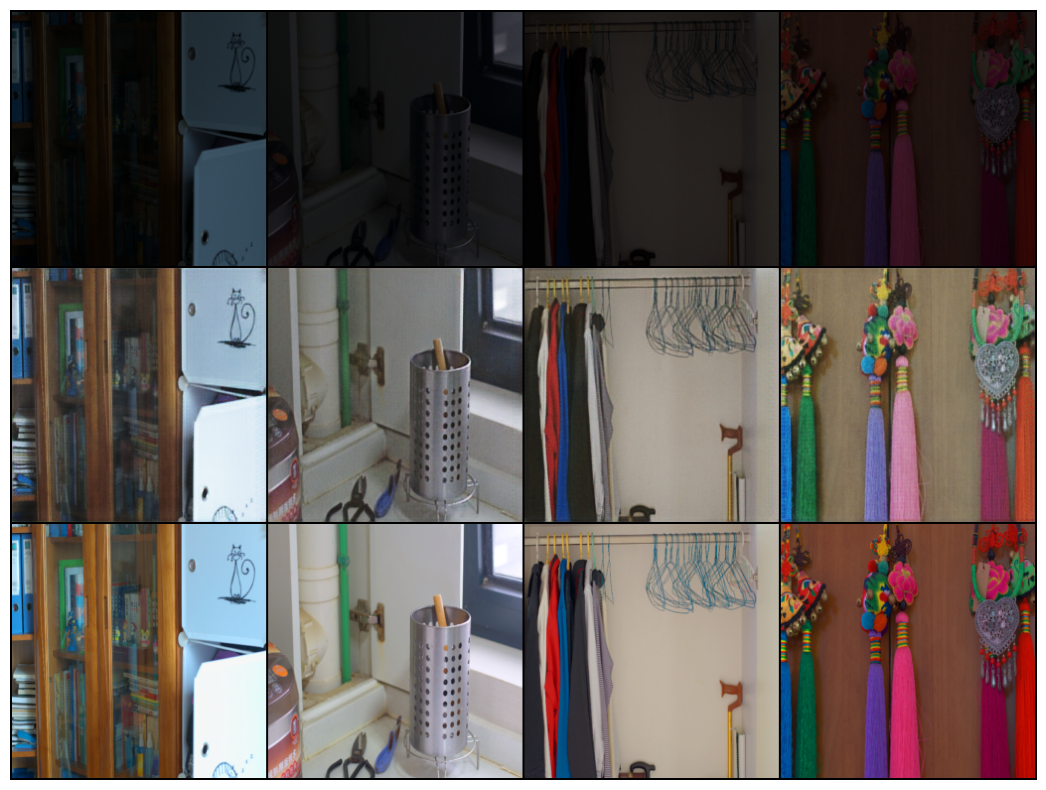

In [36]:
img_path = "samples/comparison_epoch_50.png"

# Load an image file
image = plt.imread(img_path)

plt.figure(figsize=(15, 10))
# Display the image
plt.imshow(image)
plt.axis('off')  # Remove axis ticks and labels
plt.show()  #

# Research Paper Link
https://www.researchgate.net/publication/391705093_Deep_Learning_for_Low-Light_Image_Enhancement